## INT2 Project
baseline from:
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [1]:
#!unzip -q /content/gdrive/MyDrive/cifar10.zip -d /content/gdrive/MyDrive/

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
import time

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:
#from torchvision.datasets.cifar import CIFAR10
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/cifar10/train"
TEST_DATA_PATH = "/content/gdrive/MyDrive/cifar10/test"

transform = transforms.Compose(
    [transforms.AutoAugment(),
     transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])


batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


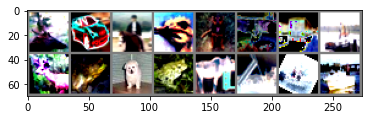

deer  car   horse bird  dog   cat   truck ship  deer  frog  dog   frog  deer  truck ship  ship 


In [5]:
# functions to show an image
(0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgGrid = torchvision.utils.make_grid(images)
imshow(imgGrid)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
writer = SummaryWriter("runs/new-VGG16") #good one?
#tensorboard --logdir runs/testValidationError
writer.add_image("four images", imgGrid)
writer.flush()

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride = 1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride = 1,  padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop1(x)
        return (x)

In [9]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

net = VGG().to(device)                                    

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [11]:
print(len(testloader))
print(len(trainloader))
start_time = time.time()
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # print statistics
        running_loss += loss.item()
    running_vloss = 0.0

    net.train(False) # Don't need to track gradents for validation
    for j, vdata in enumerate(testloader, 0):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = net(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
    net.train(True) # Turn gradients back on for training

    avg_loss = running_loss / (50000 / batch_size)
    avg_vloss = running_vloss / len(testloader)

    # Log the running loss averaged per batch
    writer.add_scalars('Training vs. Validation Loss',
              { 'Training' : avg_loss, 'Validation' : avg_vloss },
              epoch * len(trainloader) + i)
    
    if epoch % 5 == 0:
      batch_size *= 2
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
      testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

    print(f'epoch: {epoch}, loss: {running_loss / (50000 / batch_size)} time: {time.time() - start_time}')
    running_loss = 0.0
print(f'epoch time: {time.time() - start_time}')

print('Finished Training')

625
3125
epoch: 0, loss: 3.179579263877869 time: 74.08680152893066


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')